# Application: Model

## Case study: Houses for sale

## Setup

In [282]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

sns.set_theme(style="ticks", color_codes=True)

2.4.1


## Data preparation

See notebook `10a-application-model-data-exploration.ipynb` for details about data preprocessing and data exploration.

In [283]:
ROOT = "https://raw.githubusercontent.com/kirenz/modern-statistics/main/data/"
DATA = "duke-forest.csv"
df = pd.read_csv(ROOT + DATA)

# Drop irrelevant features
df = df.drop(['url', 'address', 'type'], axis=1)

# Convert data types
df['heating'] = df['heating'].astype("category")
df['cooling'] = df['cooling'].astype("category")
df['parking'] = df['parking'].astype("category")

# drop column with too many missing values
df = df.drop(['hoa'], axis=1)

df.columns.tolist()

['price',
 'bed',
 'bath',
 'area',
 'year_built',
 'heating',
 'cooling',
 'parking',
 'lot']

# Simple regression

In [284]:
# Select features for simple regression
features = ['area']
X = df[features]

X.info()
print("Missing values:",X.isnull().any(axis = 1).sum())

# Create response
y = df["price"]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98 entries, 0 to 97
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   area    98 non-null     int64
dtypes: int64(1)
memory usage: 912.0 bytes
Missing values: 0


## Data splitting

In [285]:
from sklearn.model_selection import train_test_split

# Train Test Split
# Use random_state to make this notebook's output identical at every run
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Linear regression

Start with a single-variable linear regression, to predict price from area.

Training a model with tf.keras typically starts by defining the model architecture.

In this case use a keras.Sequential model. This model represents a sequence of steps. In this case there is only one step:

- Apply a linear transformation to produce 1 output using layers.Dense.
  
The number of inputs can either be set by the input_shape argument, or automatically when the model is run for the first time.

Build the sequential model:

In [286]:
lm = tf.keras.Sequential([
    layers.Dense(units=1, input_shape=(1,))
])

lm.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


This model will predict price from area.

Run the untrained model on the first 10 area values. The output won't be good, but you'll see that it has the expected shape, (10,1):

In [287]:
lm.predict(area[:10])

array([[2636.975 ],
       [2396.1763],
       [1509.3093],
       [2498.8564],
       [2120.8477],
       [2105.4001],
       [1974.5509],
       [3565.641 ],
       [2264.4182],
       [2885.0435]], dtype=float32)

Once the model is built, configure the training procedure using the Model.compile() method. The most important arguments to compile are the loss and the optimizer since these define what will be optimized (mean_absolute_error) and how (using the optimizers.Adam).

In [288]:
lm.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

Once the training is configured, use Model.fit() to execute the training:

In [289]:
%%time
history = lm.fit(
    X_train, y_train,
    epochs=400,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.1)

CPU times: user 15.4 s, sys: 851 ms, total: 16.3 s
Wall time: 15.9 s


In [290]:
y_train

49    525000
70    520000
68    412500
15    610000
39    535000
       ...  
60    509620
71    540000
14    631500
92    590000
51    725000
Name: price, Length: 78, dtype: int64

In [316]:
# Calculate R squared
from sklearn.metrics import r2_score

y_pred = lm.predict(X_train).astype(np.int64)
y_true = y_train.astype(np.int64)

r2_score(y_train, y_pred)  

ValueError: in user code:

    /Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1478 predict_function  *
        return step_function(self, iterator)
    /Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1461 run_step  **
        outputs = model.predict_step(data)
    /Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1434 predict_step
        return self(x, training=False)
    /Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:259 assert_input_compatibility
        ' but received input with shape ' + display_shape(x.shape))

    ValueError: Input 0 of layer sequential_22 is incompatible with the layer: expected axis -1 of input shape to have value 1 but received input with shape (None, 7)


In [292]:
# slope coefficient
lm.layers[0].kernel

<tf.Variable 'dense_34/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[119.76325]], dtype=float32)>

Visualize the model's training progress using the stats stored in the history object.

In [293]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
395,244292.031250,190799.671875,395
396,243479.750000,189976.000000,396
397,242660.796875,189152.906250,397
398,241864.625000,188327.750000,398
399,241057.765625,187509.140625,399


In [294]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [price]')
  plt.legend()
  plt.grid(True)

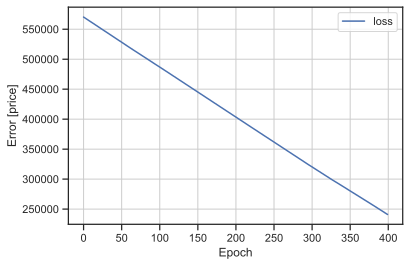

In [295]:
plot_loss(history)

Collect the results (mean squared error) on the test set, for later:

In [296]:
test_results = {}

test_results['lm'] = lm.evaluate(
    X_test,
    y_test, verbose=0)

test_results

{'lm': 274069.65625}

Since this is a single variable regression it's easy to look at the model's predictions as a function of the input:

In [297]:
x = tf.linspace(0.0, 6200, 6201)
y = area_model.predict(x)

In [298]:
def plot_area(x, y):
  plt.scatter(X_train['area'], y_train, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('area')
  plt.ylabel('price')
  plt.legend()

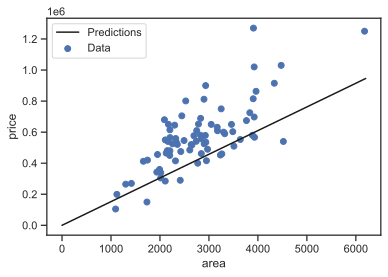

In [299]:
plot_area(x,y)

# Multiple Regression

In [300]:
# Select all relevant features
features= [
 'bed',
 'bath',
 'area',
 'year_built',
 'cooling',
 'lot'
  ]
X = df[features]

# Convert categorical to numeric
X = pd.get_dummies(X, columns=['cooling'], prefix='cooling', prefix_sep='_')

X.info()
print("Missing values:",X.isnull().any(axis = 1).sum())

# Create response
y = df["price"]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98 entries, 0 to 97
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bed              98 non-null     int64  
 1   bath             98 non-null     float64
 2   area             98 non-null     int64  
 3   year_built       98 non-null     int64  
 4   lot              97 non-null     float64
 5   cooling_central  98 non-null     uint8  
 6   cooling_other    98 non-null     uint8  
dtypes: float64(2), int64(3), uint8(2)
memory usage: 4.1 KB
Missing values: 1


In [301]:
from sklearn.model_selection import train_test_split

# Train Test Split
# Use random_state to make this notebook's output identical at every run
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [302]:
lm_2 = tf.keras.Sequential([
    layers.Dense(units=1, input_shape=(7,))
])

lm_2.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 1)                 8         
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________


In [303]:
lm_2.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [304]:
%%time
history = lm_2.fit(
    X_train, y_train,
    epochs=400,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.1)

CPU times: user 15.4 s, sys: 849 ms, total: 16.2 s
Wall time: 15.8 s


In [305]:
# Calculate R squared
from sklearn.metrics import r2_score

y_pred = lm_2.predict(X_train).astype(np.int64)
y_true = y_train.astype(np.int64)

r2_score(y_train, y_pred)  

0.2976548892124068

In [306]:
# slope coefficients
lm_2.layers[0].kernel

<tf.Variable 'dense_35/kernel:0' shape=(7, 1) dtype=float32, numpy=
array([[105.70689 ],
       [107.298996],
       [106.447495],
       [104.62231 ],
       [108.31508 ],
       [103.68888 ],
       [ 97.90066 ]], dtype=float32)>

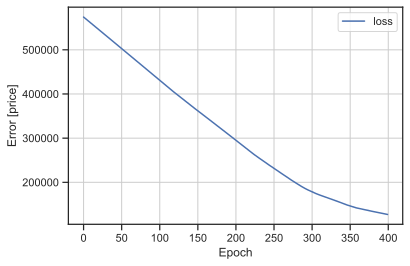

In [307]:
plot_loss(history)

In [308]:
test_results['lm_2'] = lm_2.evaluate(
    X_test, y_test, verbose=0)

# DNN regression

The previous section implemented linear models for single and multiple inputs.

This section implements a multiple-input DNN models. The code is basically the same except the model is expanded to include some "hidden" non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

- Two hidden, nonlinear, Dense layers using the relu nonlinearity.
- A linear single-output layer.

In [309]:
dnn_model = keras.Sequential([
      layers.Dense(units=1, input_shape=(7,)),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

dnn_model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))

In [310]:
%%time
history = dnn_model.fit(
    X_train, y_train,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.1)

CPU times: user 4.42 s, sys: 236 ms, total: 4.65 s
Wall time: 4.49 s


In [311]:
# Calculate R squared
from sklearn.metrics import r2_score

y_pred = dnn_model.predict(X_train).astype(np.int64)
y_true = y_train.astype(np.int64)

r2_score(y_train, y_pred)  

0.4333351711469554

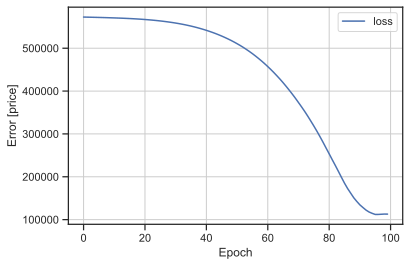

In [312]:
plot_loss(history)

In [313]:
test_results['dnn_model'] = dnn_model.evaluate(
    X_test, y_test, verbose=0)

# Performance comparison

In [315]:
pd.DataFrame(test_results, index=['Mean absolute error [price]']).T

,Mean absolute error [price]
lm,274069.65625
lm_2,156819.15625
dnn_model,147611.28125
